# FAMLY Bias metrics example usage

In [1]:
from famly.bias.report import *
from famly.util.dataset import Datasets, german_lending_readable_values
from typing import Dict
from collections import defaultdict

Get the [german lending dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). Transform the values to human readable strings from the dataset description. Dataset is functionally equivalent.


In [2]:
datasets = Datasets()
df = german_lending_readable_values(datasets('german_lending').train())
df.shape

(1000, 21)

In [3]:
df.head()

,CheckingAC_Status,MaturityMonths,CreditHistory,Purpose,LoanAmount,SavingsAC,Employment,InstalmentPctOfIncome,SexAndStatus,OtherDebts,...,Property,Age,OtherInstalmentPlans,Housing,NumExistingLoans,Job,Dependents,Telephone,ForeignWorker,target
0,x < 0 DM,6,critical accnt. / other credits,radio/tv,1169,unknown,x >= 7 years,4,male single,none,...,real estate,67,none,own,2,skilled employee / official,1,yes,yes,1
1,0 <= x < 200 DM,48,existing credits paid,radio/tv,5951,x < 100 DM,1 <= x < 4 years,2,female divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,0
2,no checking account,12,critical accnt. / other credits,education,2096,x < 100 DM,4 <= x < 7 years,2,male single,none,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,1
3,x < 0 DM,42,existing credits paid,forniture,7882,x < 100 DM,4 <= x < 7 years,2,male single,guarantor,...,soc. savings / life insurance,45,none,for free,1,skilled employee / official,2,none,yes,1
4,x < 0 DM,24,delay,new car,4870,x < 100 DM,1 <= x < 4 years,3,male single,none,...,unknown,53,none,for free,2,skilled employee / official,2,none,yes,0


In [4]:
import seaborn as sns

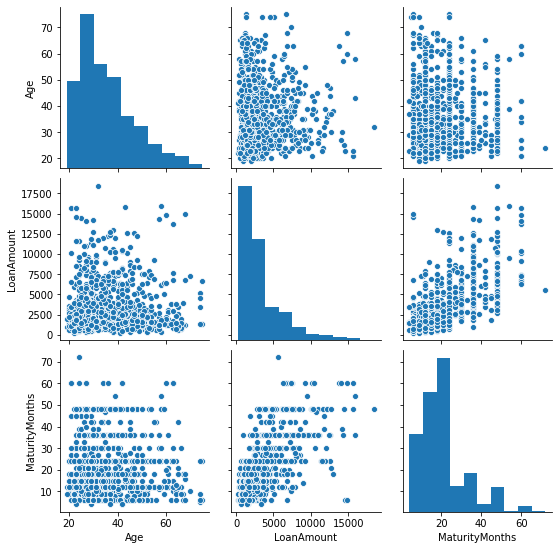

In [5]:
sns.pairplot(df[['Age','LoanAmount','MaturityMonths']])

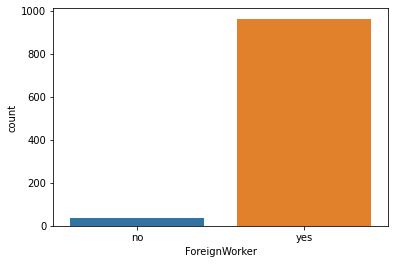

In [6]:
sns.countplot(df['ForeignWorker'])

## Calculate pre-training bias metrics

In [7]:
# Measure bias when the attribute ForeignWorker is true.
facet_column = FacetCategoricalColumn('ForeignWorker')

In [8]:
report = bias_report(df, facet_column, 'target')

In [9]:
report

{'CI': {'yes': -0.926, 'no': 0.926}}

## Train a CatBoost classifier

In [10]:
from catboost import Pool, CatBoostClassifier


In [11]:
from sklearn.model_selection import train_test_split


In [12]:
column_names = df.columns
train_cols= list(set(column_names) - set(['target']))
train, test = train_test_split(df, random_state=0)


In [13]:
train_df = train[train_cols]
test_df = test[train_cols]
train_labels = train['target']
test_labels = test['target']
cat_features = train_df.select_dtypes(include='category').columns
numeric_features = train_df.select_dtypes(include='number').columns

In [14]:
test_pool = Pool(data=test_df, label=test_labels, cat_features=cat_features)
train_pool = Pool(data=train_df, label=train_labels, cat_features=cat_features)
model = CatBoostClassifier(iterations=10, learning_rate=0.1, depth=6)
model.fit(train_pool,verbose=True)



0:	learn: 0.6569165	total: 55.7ms	remaining: 502ms
1:	learn: 0.6278780	total: 61.3ms	remaining: 245ms
2:	learn: 0.6016431	total: 66.9ms	remaining: 156ms
3:	learn: 0.5835659	total: 72.5ms	remaining: 109ms
4:	learn: 0.5712490	total: 78.4ms	remaining: 78.4ms
5:	learn: 0.5549430	total: 83.7ms	remaining: 55.8ms
6:	learn: 0.5381219	total: 88.9ms	remaining: 38.1ms
7:	learn: 0.5271915	total: 94.3ms	remaining: 23.6ms
8:	learn: 0.5165053	total: 99.7ms	remaining: 11.1ms
9:	learn: 0.5108599	total: 105ms	remaining: 0us


In [15]:
def plot_roc_curve(labels, p_pos_label):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    fpr, tpr, thrs = roc_curve(labels, p_pos_label)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [16]:
y_test = model.predict_proba(test_pool)

In [17]:
test_labels_binary=test_labels.to_numpy()


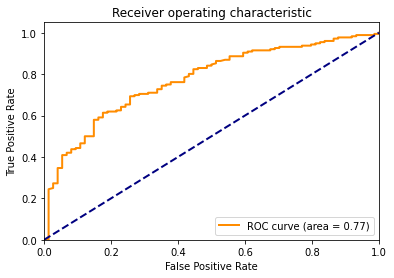

In [18]:
plot_roc_curve(test_labels_binary, y_test[:,1])

In [19]:
len(model.feature_importances_)


20

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [21]:
housing = train_df['Housing'].to_numpy()
housing = housing.reshape(-1,1)

In [22]:
def onehot(df, cat_features) -> pd.DataFrame:
    enc = OneHotEncoder(sparse=False)
    enc.fit(df[cat_features])
    res = enc.transform(df[cat_features])
    encoded_feature_names = enc.get_feature_names(cat_features)
    df_onehot = pd.DataFrame(res, columns=encoded_feature_names, index=df.index)
    other_features = list(set(df.columns)-set(cat_features))
    df_onehot = pd.concat([df_onehot, df[other_features]], axis=1)
    df_onehot[other_features] = df[other_features]
    return df_onehot, encoded_feature_names

In [23]:
train_df_onehot, encoded_feature_names = onehot(train_df, cat_features)

In [24]:
test_df_onehot, encoded_feature_names_ = onehot(test_df, cat_features)

In [25]:
test_df_onehot.head()

,SexAndStatus_female divorced/separated/married,SexAndStatus_male divorced/separated,SexAndStatus_male married/widowed,SexAndStatus_male single,Property_car or other,Property_real estate,Property_soc. savings / life insurance,Property_unknown,Purpose_appliances,Purpose_business,...,CheckingAC_Status_no checking account,CheckingAC_Status_x < 0 DM,CheckingAC_Status_x >= 200DM,InstalmentPctOfIncome,LoanAmount,NumExistingLoans,MaturityMonths,PresentResidenceYears,Age,Dependents
993,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,4,3959,1,36,3,30,1
859,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1,3577,1,9,2,26,2
298,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3,2515,1,18,4,43,1
553,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4,1995,1,12,1,27,1
672,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2,10366,1,60,4,42,1


In [26]:
assert (encoded_feature_names_ == encoded_feature_names).all()

In [27]:
assert train_df_onehot.isnull().sum().sum()==0
assert test_df_onehot.isnull().sum().sum()==0

In [28]:
lrmodel = LogisticRegression()

In [29]:
lrmodel.fit(train_df_onehot, train_labels)

/home/piotr/devel/thundera/famly/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [30]:
y_pred_lr = lrmodel.predict_proba(test_df_onehot)

In [31]:
test_labels

993    1
859    1
298    1
553    1
672    1
      ..
462    1
356    1
2      1
478    1
695    1
Name: target, Length: 250, dtype: category
Categories (2, int64): [0, 1]

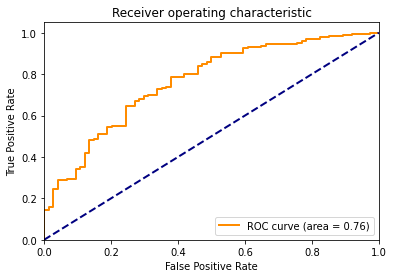

In [32]:
plot_roc_curve(test_labels, y_pred_lr[:,1])

In [33]:
train_df_onehot.columns

Index(['SexAndStatus_female divorced/separated/married',
       'SexAndStatus_male divorced/separated',
       'SexAndStatus_male married/widowed', 'SexAndStatus_male single',
       'Property_car or other', 'Property_real estate',
       'Property_soc. savings / life insurance', 'Property_unknown',
       'Purpose_appliances', 'Purpose_business', 'Purpose_education',
       'Purpose_forniture', 'Purpose_new car', 'Purpose_others',
       'Purpose_radio/tv', 'Purpose_repairs', 'Purpose_retraining',
       'Purpose_used car', 'Employment_1 <= x < 4 years',
       'Employment_4 <= x < 7 years', 'Employment_unemployed',
       'Employment_x < 1 year', 'Employment_x >= 7 years',
       'OtherDebts_co-applicant', 'OtherDebts_guarantor', 'OtherDebts_none',
       'ForeignWorker_no', 'ForeignWorker_yes', 'Housing_for free',
       'Housing_own', 'Housing_rent', 'CreditHistory_all credits paid',
       'CreditHistory_critical accnt. / other credits', 'CreditHistory_delay',
       'CreditHistor

In [34]:
test_df_onehot.shape

(250, 61)

In [35]:
def map_back(columns, cat_columns, encoded_columns) -> Dict[str, str]:
    res = {}
    for ec in encoded_columns:
        for cc in cat_columns:
            if ec.startswith(cc):
                res[ec] = cc
    res.update(zip(columns, columns))
    return res
                
    

In [36]:
feat_map = map_back(test_df.columns, cat_features, encoded_feature_names_)

In [37]:
lr_weights = list(zip(train_df_onehot.columns, lrmodel.coef_.tolist()[0]))

In [38]:
lr_weights[:5]

[('SexAndStatus_female divorced/separated/married', 0.029982468005041472),
 ('SexAndStatus_male divorced/separated', -0.14494981701320533),
 ('SexAndStatus_male married/widowed', 0.12600019191788947),
 ('SexAndStatus_male single', 0.24355444240646448),
 ('Property_car or other', -0.21407317564369785)]

In [39]:
feat_attrib = defaultdict(float)
for k,v in lr_weights:
    feat_attrib[feat_map[k]] += v
sum = 0.0
for k,v in feat_attrib.items():
    sum += v
for k in feat_attrib.keys():
    feat_attrib[k] /= sum

In [40]:
feat_attrib

defaultdict(float,
            {'SexAndStatus': 0.08377845884670698,
             'Property': 0.08377845884166643,
             'Purpose': 0.08377845884256785,
             'Employment': 0.08377845885882533,
             'OtherDebts': 0.0837784588474404,
             'ForeignWorker': 0.0837784588457332,
             'Housing': 0.08377845885862976,
             'CreditHistory': 0.08377845882259663,
             'SavingsAC': 0.08377845883607742,
             'Telephone': 0.08377845884747792,
             'Job': 0.08377845884594524,
             'OtherInstalmentPlans': 0.08377845884607098,
             'CheckingAC_Status': 0.08377845886000515,
             'InstalmentPctOfIncome': -0.08038247464987829,
             'LoanAmount': -2.0430456665330116e-05,
             'NumExistingLoans': -0.020346357113111082,
             'MaturityMonths': -0.009622243575855305,
             'PresentResidenceYears': 0.035745060727496204,
             'Age': 0.00657157129496877,
             'Dependents': -

In [41]:
feat_attrib_df = pd.DataFrame(feat_attrib.items())

In [42]:
feat_attrib_df.sort_values(by=1)

,0,1
13,InstalmentPctOfIncome,-0.080382
19,Dependents,-0.021065
15,NumExistingLoans,-0.020346
16,MaturityMonths,-0.009622
14,LoanAmount,-0.000020
18,Age,0.006572
17,PresentResidenceYears,0.035745
7,CreditHistory,0.083778
8,SavingsAC,0.083778
1,Property,0.083778


In [43]:
pd.DataFrame(list(zip(train_df.columns, model.feature_importances_.tolist()))).sort_values(by=1)

,0,1
19,Dependents,0.000000
1,SexAndStatus,0.000000
14,Job,0.000000
3,Property,0.000000
4,Purpose,0.000000
5,Employment,0.000000
6,OtherDebts,0.000000
13,Telephone,0.000000
11,SavingsAC,0.000000
9,Housing,0.653287


In [44]:
import shap

In [45]:
explainer = shap.KernelExplainer(lrmodel.predict_proba, train_df_onehot, link="logit")

Using 750 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [46]:
shap_values = explainer.shap_values(test_df_onehot, nsamples=8, l1_reg=False)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]



LinAlgError: Singular matrix

In [49]:
lrmodel.coef_.shape

(1, 61)

In [50]:
lrmodel.intercept_

array([0.26075303])

In [51]:
lrmodel.coef_

array([[ 2.99824680e-02, -1.44949817e-01,  1.26000192e-01,
         2.43554442e-01, -2.14073176e-01,  7.13788928e-01,
        -3.48186924e-02, -2.10309774e-01, -4.91198404e-02,
        -1.20307440e-01, -2.35265266e-01,  1.74179180e-01,
        -6.23821826e-01,  2.30507708e-02,  3.94267396e-01,
        -1.29876215e-01,  7.13549359e-02,  7.50125590e-01,
         2.90955011e-02,  4.14883254e-01,  1.16592908e-01,
        -4.01451605e-01,  9.54672279e-02, -1.73880562e-01,
         3.96353054e-01,  3.21147935e-02,  2.57125816e-01,
        -2.53853059e-03,  1.45383632e-01,  2.77252705e-01,
        -1.68049052e-01, -3.62930028e-01,  7.12086912e-01,
         2.58895135e-02,  3.20228570e-01, -4.40687683e-01,
        -1.68192284e-01,  1.78610423e-02,  5.71294222e-01,
        -2.95514460e-01,  1.29138765e-01, -3.58346265e-02,
         2.90421912e-01, -1.91193061e-02,  2.17913796e-01,
         5.89960233e-02, -3.20322806e-03, -1.48951039e-01,
         4.90686784e-01, -8.71484594e-02, -2.70335179e-0

In [53]:
test_df_onehot.head()

,SexAndStatus_female divorced/separated/married,SexAndStatus_male divorced/separated,SexAndStatus_male married/widowed,SexAndStatus_male single,Property_car or other,Property_real estate,Property_soc. savings / life insurance,Property_unknown,Purpose_appliances,Purpose_business,...,CheckingAC_Status_no checking account,CheckingAC_Status_x < 0 DM,CheckingAC_Status_x >= 200DM,InstalmentPctOfIncome,LoanAmount,NumExistingLoans,MaturityMonths,PresentResidenceYears,Age,Dependents
993,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,4,3959,1,36,3,30,1
859,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1,3577,1,9,2,26,2
298,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3,2515,1,18,4,43,1
553,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4,1995,1,12,1,27,1
672,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2,10366,1,60,4,42,1


In [54]:
import pickle

In [55]:
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lrmodel, f)

In [56]:
import json

In [67]:
lrmodel.coef_.shape

(1, 61)

In [68]:
lrmodel.intercept_

array([0.26075303])

In [64]:
import numpy as np

In [71]:
np.save('lrmodel_w.npz',lrmodel.coef_)

In [70]:
np.save('lrmodel_b.npz', lrmodel.intercept_)

In [ ]:
test_df_onehot.to_numpy